In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA RTX A3000 Laptop GPU


In [3]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [4]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [6]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [7]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out

In [8]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

In [9]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 128
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 65 # All sequences must be less than 1000 including class token
embed_dim = 128
classes = 10
layers = 6
channels = 3
heads = 8
epochs = 100

In [10]:
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),
    ]
)


trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

In [12]:
# del model
torch.cuda.empty_cache()

In [13]:
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads)
model

VisionTransformer(
  (patch_to_embed): Linear(in_features=48, out_features=128, bias=True)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attention): Attention(
          (query): Linear(in_features=128, out_features=128, bias=True)
          (key): Linear(in_features=128, out_features=128, bias=True)
          (value): Linear(in_features=128, out_features=128, bias=True)
          (softmax): Softmax(dim=-1)
          (activation): Identity()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feed_forward): FeedForward(
          (fc1): Linear(in_features=128, out_features=128, bias=True)
          (activation): GELU(approximate='none')
          (fc2): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

In [14]:
model = model.to(device)
from torch.amp import GradScaler
model.no_custom_backward = False
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(trainloader), epochs=epochs)
scaler = GradScaler()

In [15]:
# Get model parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")

Total Parameters: 522,058


In [16]:
# Estimate model size (assuming float32 parameters, 4 bytes each)
model_size_mb = (total_params * 4) / (1024 * 1024)
print(f"Model Size: {model_size_mb:.2f} MB")

Model Size: 1.99 MB


In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Training
from tqdm import tqdm
def train(epoch):
    print("\nTraining Epoch: %d" % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        # We do not need to specify AMP autocast in forward pass here since
        # that is taken care of already in the forward of individual modules.
        inputs, targets = inputs.to(device), targets.to(device)
        outputs,_ = model(inputs)
        # print(outputs)
        loss = criterion(outputs, targets)

        # standard pytorch AMP training setup
        # scaler also works without amp training.
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Training Accuracy:{100.*correct/total: 0.2f}")
    print(f"Training Loss:{train_loss/(batch_idx+1): 0.3f}")
    return 100.0 * correct / total, train_loss / (batch_idx + 1)


def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    print("\nTesting Epoch: %d" % epoch)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs,_ = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(f"Test Accuracy:{100.*correct/total: 0.2f}")
        print(f"Test Loss:{test_loss/(batch_idx+1): 0.3f}")
        return 100.0 * correct / total, test_loss / (batch_idx + 1)

In [19]:
import random

import numpy as np

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [20]:
from thop import profile
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, _ = profile(model, inputs=(dummy_input,), verbose=False)
print(f"FLOPs per inference step: {flops / 1e9:.2f} GFLOPs")

FLOPs per inference step: 0.03 GFLOPs


In [21]:
import time
train_accs = []
test_accs = []

# Set up CUDA memory tracking
torch.cuda.reset_peak_memory_stats(device)  # Reset memory tracking
start_time = time.time()
for epoch in range(epochs):
    epoch_start = time.time()
    # Track peak memory usage
    torch.cuda.memory_allocated(device)  # Ensure PyTorch updates memory usage tracking
    torch.cuda.reset_peak_memory_stats(device)
    
    train_acc, train_loss = train(epoch)
    test_acc, test_loss = test(epoch)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    epoch_time = time.time() - epoch_start
    print(f"Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds")
    # Track peak GPU memory usage
    peak_memory = torch.cuda.max_memory_allocated(device) / (1024**3)  # Convert to GB
    print(f"Peak GPU memory usage: {peak_memory:.2f} GB")
    
    # TFLOPs estimation for each epoch
    input_resolution = 32  # CIFAR-10 image size
    flops_per_image = (2 * total_params * input_resolution * input_resolution) / 1e12  # Approx. FLOPs per image
    total_tflops = flops_per_image * len(trainloader.dataset)  # TFLOPs per epoch
    print(f"Estimated TFLOPs for epoch {epoch+1}: {total_tflops:.4f}")
    
    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './ReVit/' + 'RevVIT' + '_CIFAR10_checkpoint.pt')
        
# End timing after training
total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

# Save final model checkpoint
final_checkpoint_path = f'./ReVIT/{'RevVIT'}_CIFAR10_final.pt'
torch.save({
    'epoch': epochs,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'train_acc': train_accs,
    'test_acc': test_accs
}, final_checkpoint_path)

print(f"Final model saved at: {final_checkpoint_path}")



Training Epoch: 0


100%|██████████| 391/391 [00:27<00:00, 14.37it/s]


Training Accuracy: 29.70
Training Loss: 1.890

Testing Epoch: 0


100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Test Accuracy: 41.86
Test Loss: 1.618
Time taken for epoch 1: 40.60 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 1: 53.4587

Training Epoch: 1


100%|██████████| 391/391 [00:26<00:00, 14.67it/s]


Training Accuracy: 38.97
Training Loss: 1.658

Testing Epoch: 1


100%|██████████| 79/79 [00:13<00:00,  5.73it/s]


Test Accuracy: 46.38
Test Loss: 1.485
Time taken for epoch 2: 40.44 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 2: 53.4587

Training Epoch: 2


100%|██████████| 391/391 [00:26<00:00, 14.84it/s]


Training Accuracy: 43.37
Training Loss: 1.558

Testing Epoch: 2


100%|██████████| 79/79 [00:13<00:00,  6.01it/s]


Test Accuracy: 48.43
Test Loss: 1.434
Time taken for epoch 3: 39.51 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 3: 53.4587

Training Epoch: 3


100%|██████████| 391/391 [00:27<00:00, 14.11it/s]


Training Accuracy: 45.37
Training Loss: 1.500

Testing Epoch: 3


100%|██████████| 79/79 [00:15<00:00,  5.25it/s]


Test Accuracy: 50.50
Test Loss: 1.387
Time taken for epoch 4: 42.76 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 4: 53.4587

Training Epoch: 4


100%|██████████| 391/391 [00:46<00:00,  8.38it/s]


Training Accuracy: 47.03
Training Loss: 1.455

Testing Epoch: 4


100%|██████████| 79/79 [00:13<00:00,  5.78it/s]


Test Accuracy: 52.00
Test Loss: 1.332
Time taken for epoch 5: 60.35 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 5: 53.4587

Training Epoch: 5


100%|██████████| 391/391 [00:29<00:00, 13.43it/s]


Training Accuracy: 48.53
Training Loss: 1.412

Testing Epoch: 5


100%|██████████| 79/79 [00:14<00:00,  5.38it/s]


Test Accuracy: 52.50
Test Loss: 1.310
Time taken for epoch 6: 43.81 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 6: 53.4587

Training Epoch: 6


100%|██████████| 391/391 [00:27<00:00, 14.22it/s]


Training Accuracy: 49.78
Training Loss: 1.386

Testing Epoch: 6


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 54.40
Test Loss: 1.269
Time taken for epoch 7: 40.24 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 7: 53.4587

Training Epoch: 7


100%|██████████| 391/391 [00:26<00:00, 14.77it/s]


Training Accuracy: 50.71
Training Loss: 1.356

Testing Epoch: 7


100%|██████████| 79/79 [00:13<00:00,  5.89it/s]


Test Accuracy: 53.77
Test Loss: 1.281
Time taken for epoch 8: 39.91 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 8: 53.4587

Training Epoch: 8


100%|██████████| 391/391 [00:27<00:00, 14.33it/s]


Training Accuracy: 51.87
Training Loss: 1.330

Testing Epoch: 8


100%|██████████| 79/79 [00:13<00:00,  6.08it/s]


Test Accuracy: 55.22
Test Loss: 1.234
Time taken for epoch 9: 40.29 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 9: 53.4587

Training Epoch: 9


100%|██████████| 391/391 [00:27<00:00, 14.39it/s]


Training Accuracy: 52.59
Training Loss: 1.313

Testing Epoch: 9


100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


Test Accuracy: 56.08
Test Loss: 1.212
Time taken for epoch 10: 39.99 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 10: 53.4587

Training Epoch: 10


100%|██████████| 391/391 [00:26<00:00, 14.60it/s]


Training Accuracy: 53.42
Training Loss: 1.289

Testing Epoch: 10


100%|██████████| 79/79 [00:13<00:00,  5.68it/s]


Test Accuracy: 56.97
Test Loss: 1.202
Time taken for epoch 11: 40.70 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 11: 53.4587

Training Epoch: 11


100%|██████████| 391/391 [00:30<00:00, 12.98it/s]


Training Accuracy: 53.98
Training Loss: 1.271

Testing Epoch: 11


100%|██████████| 79/79 [00:14<00:00,  5.62it/s]


Test Accuracy: 57.62
Test Loss: 1.175
Time taken for epoch 12: 44.20 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 12: 53.4587

Training Epoch: 12


100%|██████████| 391/391 [00:27<00:00, 13.98it/s]


Training Accuracy: 54.45
Training Loss: 1.260

Testing Epoch: 12


100%|██████████| 79/79 [00:18<00:00,  4.22it/s]


Test Accuracy: 58.12
Test Loss: 1.165
Time taken for epoch 13: 46.69 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 13: 53.4587

Training Epoch: 13


100%|██████████| 391/391 [00:28<00:00, 13.94it/s]


Training Accuracy: 55.14
Training Loss: 1.241

Testing Epoch: 13


100%|██████████| 79/79 [00:13<00:00,  6.07it/s]


Test Accuracy: 58.90
Test Loss: 1.145
Time taken for epoch 14: 41.07 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 14: 53.4587

Training Epoch: 14


100%|██████████| 391/391 [00:26<00:00, 14.64it/s]


Training Accuracy: 55.78
Training Loss: 1.224

Testing Epoch: 14


100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Test Accuracy: 58.90
Test Loss: 1.134
Time taken for epoch 15: 39.32 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 15: 53.4587

Training Epoch: 15


100%|██████████| 391/391 [00:26<00:00, 14.98it/s]


Training Accuracy: 56.11
Training Loss: 1.218

Testing Epoch: 15


100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Test Accuracy: 59.61
Test Loss: 1.121
Time taken for epoch 16: 38.71 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 16: 53.4587

Training Epoch: 16


100%|██████████| 391/391 [00:26<00:00, 14.85it/s]


Training Accuracy: 56.79
Training Loss: 1.199

Testing Epoch: 16


100%|██████████| 79/79 [00:14<00:00,  5.54it/s]


Test Accuracy: 59.82
Test Loss: 1.111
Time taken for epoch 17: 40.59 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 17: 53.4587

Training Epoch: 17


100%|██████████| 391/391 [00:26<00:00, 14.98it/s]


Training Accuracy: 57.46
Training Loss: 1.181

Testing Epoch: 17


100%|██████████| 79/79 [00:12<00:00,  6.28it/s]


Test Accuracy: 60.07
Test Loss: 1.102
Time taken for epoch 18: 38.69 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 18: 53.4587

Training Epoch: 18


100%|██████████| 391/391 [00:25<00:00, 15.17it/s]


Training Accuracy: 57.94
Training Loss: 1.176

Testing Epoch: 18


100%|██████████| 79/79 [00:12<00:00,  6.29it/s]


Test Accuracy: 60.83
Test Loss: 1.089
Time taken for epoch 19: 38.34 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 19: 53.4587

Training Epoch: 19


100%|██████████| 391/391 [00:26<00:00, 14.91it/s]


Training Accuracy: 57.95
Training Loss: 1.167

Testing Epoch: 19


100%|██████████| 79/79 [00:12<00:00,  6.28it/s]


Test Accuracy: 60.87
Test Loss: 1.078
Time taken for epoch 20: 38.81 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 20: 53.4587

Training Epoch: 20


100%|██████████| 391/391 [00:26<00:00, 14.98it/s]


Training Accuracy: 58.26
Training Loss: 1.157

Testing Epoch: 20


100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


Test Accuracy: 61.16
Test Loss: 1.072
Time taken for epoch 21: 38.93 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 21: 53.4587

Training Epoch: 21


100%|██████████| 391/391 [00:26<00:00, 14.84it/s]


Training Accuracy: 59.16
Training Loss: 1.142

Testing Epoch: 21


100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


Test Accuracy: 61.89
Test Loss: 1.064
Time taken for epoch 22: 39.45 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 22: 53.4587

Training Epoch: 22


100%|██████████| 391/391 [00:26<00:00, 14.91it/s]


Training Accuracy: 59.53
Training Loss: 1.128

Testing Epoch: 22


100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


Test Accuracy: 61.93
Test Loss: 1.059
Time taken for epoch 23: 38.48 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 23: 53.4587

Training Epoch: 23


100%|██████████| 391/391 [00:25<00:00, 15.20it/s]


Training Accuracy: 59.70
Training Loss: 1.120

Testing Epoch: 23


100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Test Accuracy: 61.93
Test Loss: 1.052
Time taken for epoch 24: 38.46 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 24: 53.4587

Training Epoch: 24


100%|██████████| 391/391 [00:26<00:00, 14.86it/s]


Training Accuracy: 60.02
Training Loss: 1.113

Testing Epoch: 24


100%|██████████| 79/79 [00:12<00:00,  6.26it/s]


Test Accuracy: 62.48
Test Loss: 1.036
Time taken for epoch 25: 38.95 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 25: 53.4587

Training Epoch: 25


100%|██████████| 391/391 [00:26<00:00, 14.73it/s]


Training Accuracy: 60.62
Training Loss: 1.102

Testing Epoch: 25


100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Test Accuracy: 62.60
Test Loss: 1.032
Time taken for epoch 26: 39.49 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 26: 53.4587

Training Epoch: 26


100%|██████████| 391/391 [00:29<00:00, 13.14it/s]


Training Accuracy: 61.14
Training Loss: 1.088

Testing Epoch: 26


100%|██████████| 79/79 [00:13<00:00,  5.99it/s]


Test Accuracy: 63.42
Test Loss: 1.017
Time taken for epoch 27: 42.95 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 27: 53.4587

Training Epoch: 27


100%|██████████| 391/391 [00:27<00:00, 14.06it/s]


Training Accuracy: 61.00
Training Loss: 1.084

Testing Epoch: 27


100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


Test Accuracy: 63.78
Test Loss: 1.010
Time taken for epoch 28: 40.67 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 28: 53.4587

Training Epoch: 28


100%|██████████| 391/391 [00:26<00:00, 14.97it/s]


Training Accuracy: 61.35
Training Loss: 1.073

Testing Epoch: 28


100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Test Accuracy: 63.72
Test Loss: 1.019
Time taken for epoch 29: 38.80 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 29: 53.4587

Training Epoch: 29


100%|██████████| 391/391 [00:26<00:00, 14.76it/s]


Training Accuracy: 61.84
Training Loss: 1.065

Testing Epoch: 29


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 64.64
Test Loss: 0.994
Time taken for epoch 30: 39.39 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 30: 53.4587

Training Epoch: 30


100%|██████████| 391/391 [00:26<00:00, 14.66it/s]


Training Accuracy: 62.25
Training Loss: 1.057

Testing Epoch: 30


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 64.02
Test Loss: 1.001
Time taken for epoch 31: 39.77 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 31: 53.4587

Training Epoch: 31


100%|██████████| 391/391 [00:26<00:00, 14.65it/s]


Training Accuracy: 62.28
Training Loss: 1.050

Testing Epoch: 31


100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


Test Accuracy: 64.10
Test Loss: 0.990
Time taken for epoch 32: 39.58 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 32: 53.4587

Training Epoch: 32


100%|██████████| 391/391 [00:26<00:00, 14.74it/s]


Training Accuracy: 62.84
Training Loss: 1.040

Testing Epoch: 32


100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


Test Accuracy: 65.01
Test Loss: 0.984
Time taken for epoch 33: 39.38 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 33: 53.4587

Training Epoch: 33


100%|██████████| 391/391 [00:26<00:00, 14.99it/s]


Training Accuracy: 62.90
Training Loss: 1.037

Testing Epoch: 33


100%|██████████| 79/79 [00:12<00:00,  6.34it/s]


Test Accuracy: 64.94
Test Loss: 0.970
Time taken for epoch 34: 38.55 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 34: 53.4587

Training Epoch: 34


100%|██████████| 391/391 [00:25<00:00, 15.12it/s]


Training Accuracy: 63.37
Training Loss: 1.026

Testing Epoch: 34


100%|██████████| 79/79 [00:12<00:00,  6.40it/s]


Test Accuracy: 65.31
Test Loss: 0.966
Time taken for epoch 35: 38.22 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 35: 53.4587

Training Epoch: 35


100%|██████████| 391/391 [00:25<00:00, 15.13it/s]


Training Accuracy: 63.28
Training Loss: 1.024

Testing Epoch: 35


100%|██████████| 79/79 [00:12<00:00,  6.32it/s]


Test Accuracy: 65.93
Test Loss: 0.958
Time taken for epoch 36: 38.34 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 36: 53.4587

Training Epoch: 36


100%|██████████| 391/391 [00:25<00:00, 15.23it/s]


Training Accuracy: 63.98
Training Loss: 1.004

Testing Epoch: 36


100%|██████████| 79/79 [00:12<00:00,  6.33it/s]


Test Accuracy: 65.56
Test Loss: 0.957
Time taken for epoch 37: 38.17 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 37: 53.4587

Training Epoch: 37


100%|██████████| 391/391 [00:25<00:00, 15.12it/s]


Training Accuracy: 64.38
Training Loss: 1.002

Testing Epoch: 37


100%|██████████| 79/79 [00:12<00:00,  6.41it/s]


Test Accuracy: 66.14
Test Loss: 0.947
Time taken for epoch 38: 38.18 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 38: 53.4587

Training Epoch: 38


100%|██████████| 391/391 [00:25<00:00, 15.06it/s]


Training Accuracy: 64.63
Training Loss: 0.993

Testing Epoch: 38


100%|██████████| 79/79 [00:12<00:00,  6.47it/s]


Test Accuracy: 65.94
Test Loss: 0.953
Time taken for epoch 39: 38.18 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 39: 53.4587

Training Epoch: 39


100%|██████████| 391/391 [00:25<00:00, 15.08it/s]


Training Accuracy: 64.79
Training Loss: 0.989

Testing Epoch: 39


100%|██████████| 79/79 [00:12<00:00,  6.35it/s]


Test Accuracy: 66.47
Test Loss: 0.936
Time taken for epoch 40: 38.40 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 40: 53.4587

Training Epoch: 40


100%|██████████| 391/391 [00:26<00:00, 15.01it/s]


Training Accuracy: 65.01
Training Loss: 0.980

Testing Epoch: 40


100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


Test Accuracy: 66.20
Test Loss: 0.938
Time taken for epoch 41: 38.58 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 41: 53.4587

Training Epoch: 41


100%|██████████| 391/391 [00:25<00:00, 15.23it/s]


Training Accuracy: 65.31
Training Loss: 0.974

Testing Epoch: 41


100%|██████████| 79/79 [00:12<00:00,  6.32it/s]


Test Accuracy: 66.76
Test Loss: 0.920
Time taken for epoch 42: 38.17 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 42: 53.4587

Training Epoch: 42


100%|██████████| 391/391 [00:25<00:00, 15.08it/s]


Training Accuracy: 65.39
Training Loss: 0.966

Testing Epoch: 42


100%|██████████| 79/79 [00:12<00:00,  6.34it/s]


Test Accuracy: 67.28
Test Loss: 0.916
Time taken for epoch 43: 38.40 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 43: 53.4587

Training Epoch: 43


100%|██████████| 391/391 [00:26<00:00, 15.02it/s]


Training Accuracy: 66.13
Training Loss: 0.955

Testing Epoch: 43


100%|██████████| 79/79 [00:13<00:00,  5.67it/s]


Test Accuracy: 67.26
Test Loss: 0.918
Time taken for epoch 44: 39.98 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 44: 53.4587

Training Epoch: 44


100%|██████████| 391/391 [00:26<00:00, 14.65it/s]


Training Accuracy: 66.11
Training Loss: 0.956

Testing Epoch: 44


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 66.73
Test Loss: 0.926
Time taken for epoch 45: 39.60 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 45: 53.4587

Training Epoch: 45


100%|██████████| 391/391 [00:26<00:00, 14.66it/s]


Training Accuracy: 66.28
Training Loss: 0.943

Testing Epoch: 45


100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Test Accuracy: 67.71
Test Loss: 0.907
Time taken for epoch 46: 39.38 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 46: 53.4587

Training Epoch: 46


100%|██████████| 391/391 [00:26<00:00, 14.60it/s]


Training Accuracy: 66.61
Training Loss: 0.938

Testing Epoch: 46


100%|██████████| 79/79 [00:12<00:00,  6.30it/s]


Test Accuracy: 67.72
Test Loss: 0.908
Time taken for epoch 47: 39.32 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 47: 53.4587

Training Epoch: 47


100%|██████████| 391/391 [00:25<00:00, 15.12it/s]


Training Accuracy: 66.70
Training Loss: 0.932

Testing Epoch: 47


100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


Test Accuracy: 67.91
Test Loss: 0.899
Time taken for epoch 48: 38.38 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 48: 53.4587

Training Epoch: 48


100%|██████████| 391/391 [00:25<00:00, 15.22it/s]


Training Accuracy: 67.01
Training Loss: 0.927

Testing Epoch: 48


100%|██████████| 79/79 [00:12<00:00,  6.30it/s]


Test Accuracy: 67.76
Test Loss: 0.893
Time taken for epoch 49: 38.24 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 49: 53.4587

Training Epoch: 49


100%|██████████| 391/391 [00:26<00:00, 14.90it/s]


Training Accuracy: 66.98
Training Loss: 0.922

Testing Epoch: 49


100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Test Accuracy: 68.52
Test Loss: 0.878
Time taken for epoch 50: 39.19 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 50: 53.4587

Training Epoch: 50


100%|██████████| 391/391 [00:26<00:00, 14.75it/s]


Training Accuracy: 67.43
Training Loss: 0.912

Testing Epoch: 50


100%|██████████| 79/79 [00:13<00:00,  5.79it/s]


Test Accuracy: 68.22
Test Loss: 0.878
Time taken for epoch 51: 40.16 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 51: 53.4587

Training Epoch: 51


100%|██████████| 391/391 [00:27<00:00, 14.36it/s]


Training Accuracy: 67.60
Training Loss: 0.916

Testing Epoch: 51


100%|██████████| 79/79 [00:13<00:00,  5.98it/s]


Test Accuracy: 68.35
Test Loss: 0.877
Time taken for epoch 52: 40.43 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 52: 53.4587

Training Epoch: 52


100%|██████████| 391/391 [00:27<00:00, 14.42it/s]


Training Accuracy: 67.75
Training Loss: 0.904

Testing Epoch: 52


100%|██████████| 79/79 [00:13<00:00,  6.06it/s]


Test Accuracy: 68.88
Test Loss: 0.870
Time taken for epoch 53: 40.15 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 53: 53.4587

Training Epoch: 53


100%|██████████| 391/391 [00:26<00:00, 14.67it/s]


Training Accuracy: 68.07
Training Loss: 0.894

Testing Epoch: 53


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 68.83
Test Loss: 0.881
Time taken for epoch 54: 39.56 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 54: 53.4587

Training Epoch: 54


100%|██████████| 391/391 [00:26<00:00, 14.70it/s]


Training Accuracy: 68.37
Training Loss: 0.891

Testing Epoch: 54


100%|██████████| 79/79 [00:12<00:00,  6.28it/s]


Test Accuracy: 69.27
Test Loss: 0.863
Time taken for epoch 55: 39.18 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 55: 53.4587

Training Epoch: 55


100%|██████████| 391/391 [00:26<00:00, 14.93it/s]


Training Accuracy: 68.80
Training Loss: 0.882

Testing Epoch: 55


100%|██████████| 79/79 [00:13<00:00,  6.08it/s]


Test Accuracy: 68.76
Test Loss: 0.865
Time taken for epoch 56: 39.19 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 56: 53.4587

Training Epoch: 56


100%|██████████| 391/391 [00:26<00:00, 14.66it/s]


Training Accuracy: 68.75
Training Loss: 0.878

Testing Epoch: 56


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 69.71
Test Loss: 0.843
Time taken for epoch 57: 39.75 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 57: 53.4587

Training Epoch: 57


100%|██████████| 391/391 [00:26<00:00, 14.74it/s]


Training Accuracy: 69.21
Training Loss: 0.868

Testing Epoch: 57


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 69.60
Test Loss: 0.844
Time taken for epoch 58: 39.62 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 58: 53.4587

Training Epoch: 58


100%|██████████| 391/391 [00:26<00:00, 14.68it/s]


Training Accuracy: 69.17
Training Loss: 0.865

Testing Epoch: 58


100%|██████████| 79/79 [00:13<00:00,  6.01it/s]


Test Accuracy: 70.17
Test Loss: 0.843
Time taken for epoch 59: 39.78 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 59: 53.4587

Training Epoch: 59


100%|██████████| 391/391 [00:26<00:00, 14.70it/s]


Training Accuracy: 69.28
Training Loss: 0.859

Testing Epoch: 59


100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


Test Accuracy: 69.76
Test Loss: 0.850
Time taken for epoch 60: 39.60 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 60: 53.4587

Training Epoch: 60


100%|██████████| 391/391 [00:26<00:00, 14.69it/s]


Training Accuracy: 69.47
Training Loss: 0.861

Testing Epoch: 60


100%|██████████| 79/79 [00:18<00:00,  4.27it/s]


Test Accuracy: 69.61
Test Loss: 0.842
Time taken for epoch 61: 45.12 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 61: 53.4587

Training Epoch: 61


100%|██████████| 391/391 [00:26<00:00, 14.99it/s]


Training Accuracy: 69.95
Training Loss: 0.848

Testing Epoch: 61


100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Test Accuracy: 70.44
Test Loss: 0.836
Time taken for epoch 62: 38.74 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 62: 53.4587

Training Epoch: 62


100%|██████████| 391/391 [00:25<00:00, 15.09it/s]


Training Accuracy: 70.27
Training Loss: 0.838

Testing Epoch: 62


100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Test Accuracy: 70.45
Test Loss: 0.823
Time taken for epoch 63: 38.60 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 63: 53.4587

Training Epoch: 63


100%|██████████| 391/391 [00:25<00:00, 15.07it/s]


Training Accuracy: 69.99
Training Loss: 0.839

Testing Epoch: 63


100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Test Accuracy: 70.58
Test Loss: 0.828
Time taken for epoch 64: 38.58 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 64: 53.4587

Training Epoch: 64


100%|██████████| 391/391 [00:25<00:00, 15.08it/s]


Training Accuracy: 70.51
Training Loss: 0.830

Testing Epoch: 64


100%|██████████| 79/79 [00:12<00:00,  6.35it/s]


Test Accuracy: 71.11
Test Loss: 0.820
Time taken for epoch 65: 38.38 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 65: 53.4587

Training Epoch: 65


100%|██████████| 391/391 [00:25<00:00, 15.09it/s]


Training Accuracy: 70.37
Training Loss: 0.831

Testing Epoch: 65


100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


Test Accuracy: 70.49
Test Loss: 0.835
Time taken for epoch 66: 38.76 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 66: 53.4587

Training Epoch: 66


100%|██████████| 391/391 [00:26<00:00, 14.76it/s]


Training Accuracy: 70.59
Training Loss: 0.829

Testing Epoch: 66


100%|██████████| 79/79 [00:12<00:00,  6.35it/s]


Test Accuracy: 71.10
Test Loss: 0.813
Time taken for epoch 67: 38.96 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 67: 53.4587

Training Epoch: 67


100%|██████████| 391/391 [00:26<00:00, 14.96it/s]


Training Accuracy: 70.86
Training Loss: 0.815

Testing Epoch: 67


100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Test Accuracy: 70.89
Test Loss: 0.813
Time taken for epoch 68: 38.76 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 68: 53.4587

Training Epoch: 68


100%|██████████| 391/391 [00:25<00:00, 15.07it/s]


Training Accuracy: 70.69
Training Loss: 0.818

Testing Epoch: 68


100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


Test Accuracy: 71.31
Test Loss: 0.806
Time taken for epoch 69: 38.63 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 69: 53.4587

Training Epoch: 69


100%|██████████| 391/391 [00:25<00:00, 15.22it/s]


Training Accuracy: 71.21
Training Loss: 0.810

Testing Epoch: 69


100%|██████████| 79/79 [00:12<00:00,  6.35it/s]


Test Accuracy: 70.68
Test Loss: 0.811
Time taken for epoch 70: 38.13 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 70: 53.4587

Training Epoch: 70


100%|██████████| 391/391 [00:25<00:00, 15.09it/s]


Training Accuracy: 71.32
Training Loss: 0.802

Testing Epoch: 70


100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Test Accuracy: 71.57
Test Loss: 0.805
Time taken for epoch 71: 38.57 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 71: 53.4587

Training Epoch: 71


100%|██████████| 391/391 [00:25<00:00, 15.06it/s]


Training Accuracy: 71.90
Training Loss: 0.794

Testing Epoch: 71


100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Test Accuracy: 71.54
Test Loss: 0.800
Time taken for epoch 72: 38.56 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 72: 53.4587

Training Epoch: 72


100%|██████████| 391/391 [00:26<00:00, 14.95it/s]


Training Accuracy: 72.15
Training Loss: 0.792

Testing Epoch: 72


100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


Test Accuracy: 71.18
Test Loss: 0.803
Time taken for epoch 73: 39.03 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 73: 53.4587

Training Epoch: 73


100%|██████████| 391/391 [00:26<00:00, 14.76it/s]


Training Accuracy: 71.91
Training Loss: 0.788

Testing Epoch: 73


100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


Test Accuracy: 71.71
Test Loss: 0.801
Time taken for epoch 74: 39.64 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 74: 53.4587

Training Epoch: 74


100%|██████████| 391/391 [00:26<00:00, 14.77it/s]


Training Accuracy: 72.43
Training Loss: 0.780

Testing Epoch: 74


100%|██████████| 79/79 [00:13<00:00,  5.95it/s]


Test Accuracy: 71.74
Test Loss: 0.790
Time taken for epoch 75: 39.75 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 75: 53.4587

Training Epoch: 75


100%|██████████| 391/391 [00:26<00:00, 14.55it/s]


Training Accuracy: 72.24
Training Loss: 0.778

Testing Epoch: 75


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 71.83
Test Loss: 0.782
Time taken for epoch 76: 39.96 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 76: 53.4587

Training Epoch: 76


100%|██████████| 391/391 [00:26<00:00, 14.92it/s]


Training Accuracy: 72.27
Training Loss: 0.772

Testing Epoch: 76


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 71.66
Test Loss: 0.792
Time taken for epoch 77: 39.14 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 77: 53.4587

Training Epoch: 77


100%|██████████| 391/391 [00:26<00:00, 14.74it/s]


Training Accuracy: 72.50
Training Loss: 0.771

Testing Epoch: 77


100%|██████████| 79/79 [00:13<00:00,  5.85it/s]


Test Accuracy: 72.73
Test Loss: 0.770
Time taken for epoch 78: 40.03 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 78: 53.4587

Training Epoch: 78


100%|██████████| 391/391 [00:26<00:00, 14.68it/s]


Training Accuracy: 72.84
Training Loss: 0.765

Testing Epoch: 78


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 72.52
Test Loss: 0.769
Time taken for epoch 79: 39.37 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 79: 53.4587

Training Epoch: 79


100%|██████████| 391/391 [00:26<00:00, 14.79it/s]


Training Accuracy: 72.87
Training Loss: 0.760

Testing Epoch: 79


100%|██████████| 79/79 [00:13<00:00,  5.74it/s]


Test Accuracy: 72.34
Test Loss: 0.771
Time taken for epoch 80: 40.21 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 80: 53.4587

Training Epoch: 80


100%|██████████| 391/391 [00:26<00:00, 14.72it/s]


Training Accuracy: 73.29
Training Loss: 0.754

Testing Epoch: 80


100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Test Accuracy: 72.88
Test Loss: 0.769
Time taken for epoch 81: 39.28 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 81: 53.4587

Training Epoch: 81


100%|██████████| 391/391 [00:26<00:00, 14.84it/s]


Training Accuracy: 73.49
Training Loss: 0.745

Testing Epoch: 81


100%|██████████| 79/79 [00:13<00:00,  5.78it/s]


Test Accuracy: 73.21
Test Loss: 0.763
Time taken for epoch 82: 40.02 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 82: 53.4587

Training Epoch: 82


100%|██████████| 391/391 [00:26<00:00, 14.75it/s]


Training Accuracy: 73.69
Training Loss: 0.739

Testing Epoch: 82


100%|██████████| 79/79 [00:13<00:00,  5.90it/s]


Test Accuracy: 72.63
Test Loss: 0.765
Time taken for epoch 83: 39.90 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 83: 53.4587

Training Epoch: 83


100%|██████████| 391/391 [00:26<00:00, 14.81it/s]


Training Accuracy: 73.64
Training Loss: 0.741

Testing Epoch: 83


100%|██████████| 79/79 [00:13<00:00,  5.98it/s]


Test Accuracy: 72.82
Test Loss: 0.773
Time taken for epoch 84: 39.61 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 84: 53.4587

Training Epoch: 84


100%|██████████| 391/391 [00:27<00:00, 14.38it/s]


Training Accuracy: 73.97
Training Loss: 0.737

Testing Epoch: 84


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 72.83
Test Loss: 0.764
Time taken for epoch 85: 40.27 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 85: 53.4587

Training Epoch: 85


100%|██████████| 391/391 [00:26<00:00, 14.66it/s]


Training Accuracy: 74.07
Training Loss: 0.731

Testing Epoch: 85


100%|██████████| 79/79 [00:13<00:00,  5.94it/s]


Test Accuracy: 73.85
Test Loss: 0.746
Time taken for epoch 86: 39.98 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 86: 53.4587

Training Epoch: 86


100%|██████████| 391/391 [00:27<00:00, 14.38it/s]


Training Accuracy: 74.17
Training Loss: 0.730

Testing Epoch: 86


100%|██████████| 79/79 [00:13<00:00,  6.00it/s]


Test Accuracy: 73.26
Test Loss: 0.759
Time taken for epoch 87: 40.35 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 87: 53.4587

Training Epoch: 87


100%|██████████| 391/391 [00:26<00:00, 14.79it/s]


Training Accuracy: 74.45
Training Loss: 0.718

Testing Epoch: 87


100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


Test Accuracy: 73.23
Test Loss: 0.757
Time taken for epoch 88: 39.57 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 88: 53.4587

Training Epoch: 88


100%|██████████| 391/391 [00:26<00:00, 14.78it/s]


Training Accuracy: 74.48
Training Loss: 0.717

Testing Epoch: 88


100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


Test Accuracy: 73.52
Test Loss: 0.747
Time taken for epoch 89: 39.44 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 89: 53.4587

Training Epoch: 89


100%|██████████| 391/391 [00:26<00:00, 14.72it/s]


Training Accuracy: 74.64
Training Loss: 0.712

Testing Epoch: 89


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 73.24
Test Loss: 0.762
Time taken for epoch 90: 39.32 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 90: 53.4587

Training Epoch: 90


100%|██████████| 391/391 [00:26<00:00, 15.00it/s]


Training Accuracy: 74.91
Training Loss: 0.706

Testing Epoch: 90


100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


Test Accuracy: 73.83
Test Loss: 0.750
Time taken for epoch 91: 38.71 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 91: 53.4587

Training Epoch: 91


100%|██████████| 391/391 [00:25<00:00, 15.07it/s]


Training Accuracy: 75.00
Training Loss: 0.704

Testing Epoch: 91


100%|██████████| 79/79 [00:12<00:00,  6.32it/s]


Test Accuracy: 73.94
Test Loss: 0.741
Time taken for epoch 92: 38.46 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 92: 53.4587

Training Epoch: 92


100%|██████████| 391/391 [00:25<00:00, 15.11it/s]


Training Accuracy: 75.32
Training Loss: 0.696

Testing Epoch: 92


100%|██████████| 79/79 [00:12<00:00,  6.34it/s]


Test Accuracy: 73.74
Test Loss: 0.749
Time taken for epoch 93: 38.32 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 93: 53.4587

Training Epoch: 93


100%|██████████| 391/391 [00:25<00:00, 15.07it/s]


Training Accuracy: 75.34
Training Loss: 0.696

Testing Epoch: 93


100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Test Accuracy: 73.77
Test Loss: 0.741
Time taken for epoch 94: 38.67 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 94: 53.4587

Training Epoch: 94


100%|██████████| 391/391 [00:26<00:00, 14.53it/s]


Training Accuracy: 75.56
Training Loss: 0.690

Testing Epoch: 94


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 74.29
Test Loss: 0.733
Time taken for epoch 95: 40.00 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 95: 53.4587

Training Epoch: 95


100%|██████████| 391/391 [00:26<00:00, 14.71it/s]


Training Accuracy: 75.56
Training Loss: 0.687

Testing Epoch: 95


100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


Test Accuracy: 74.76
Test Loss: 0.727
Time taken for epoch 96: 39.64 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 96: 53.4587

Training Epoch: 96


100%|██████████| 391/391 [00:26<00:00, 14.91it/s]


Training Accuracy: 75.83
Training Loss: 0.680

Testing Epoch: 96


100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


Test Accuracy: 74.15
Test Loss: 0.731
Time taken for epoch 97: 39.02 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 97: 53.4587

Training Epoch: 97


100%|██████████| 391/391 [00:26<00:00, 14.66it/s]


Training Accuracy: 75.95
Training Loss: 0.674

Testing Epoch: 97


100%|██████████| 79/79 [00:13<00:00,  6.00it/s]


Test Accuracy: 73.86
Test Loss: 0.740
Time taken for epoch 98: 39.83 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 98: 53.4587

Training Epoch: 98


100%|██████████| 391/391 [00:25<00:00, 15.04it/s]


Training Accuracy: 76.16
Training Loss: 0.673

Testing Epoch: 98


100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


Test Accuracy: 73.89
Test Loss: 0.734
Time taken for epoch 99: 38.97 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 99: 53.4587

Training Epoch: 99


100%|██████████| 391/391 [00:26<00:00, 14.66it/s]


Training Accuracy: 76.09
Training Loss: 0.673

Testing Epoch: 99


100%|██████████| 79/79 [00:13<00:00,  6.05it/s]

Test Accuracy: 74.62
Test Loss: 0.726
Time taken for epoch 100: 39.73 seconds
Peak GPU memory usage: 0.49 GB
Estimated TFLOPs for epoch 100: 53.4587
Total training time: 3981.00 seconds
Final model saved at: ./ReVIT/RevVIT_CIFAR10_final.pt


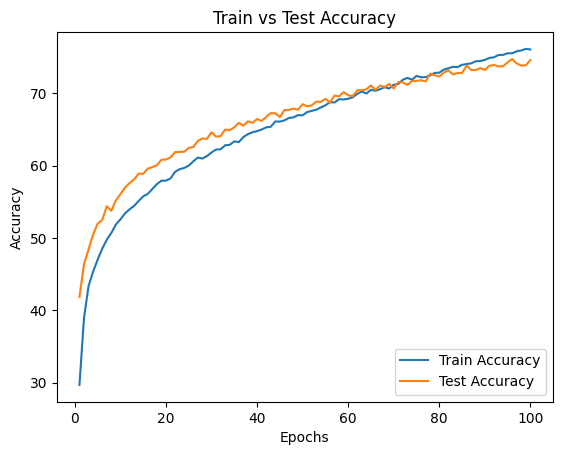

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
train_accs_gpu = train_accs.copy()
test_accs_gpu = test_accs.copy()
# train_accs_cpu = [acc.cpu().item() for acc in train_accs_gpu]
# test_accs_cpu = [acc.cpu().item() for acc in test_accs_gpu]
# print(train_accs)
# print(test_accs)
plt.plot(range(1, 101), train_accs_gpu, label='Train Accuracy')
plt.plot(range(1, 101), test_accs_gpu, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

In [1]:
import time
import torch
import psutil
import os

# Example: Using a DataLoader for test data
def measure_metrics(model, dataloader, device):
    model.to(device)
    model.eval()

    total_inference_time = 0.0
    total_tokens = 0
    total_images = 0
    correct = 0
    total_memory_usage = 0.0
    total_cpu_usage = 0.0

    # Process object for CPU usage monitoring
    process = psutil.Process(os.getpid())

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Reset CUDA peak memory stats for this batch
            torch.cuda.reset_peak_memory_stats(device)

            # Capture CPU usage before inference (non-blocking, instantaneous)
            cpu_before = psutil.cpu_percent(interval=None)
            start_time = time.time()

            # Assume model outputs either logits or a tuple (logits, token_counts)
            outputs = model(images)
            if isinstance(outputs, tuple):
                logits, token_counts = outputs
            else:
                logits = outputs
                # For baseline VIT, token count can be set as a constant, e.g., number of patches
                token_counts = torch.full((images.size(0),), images.shape[1], dtype=torch.float32)

            end_time = time.time()
            cpu_after = psutil.cpu_percent(interval=None)
            inference_time = end_time - start_time
            total_inference_time += inference_time
            total_images += images.size(0)
            # Average CPU usage for this batch
            batch_cpu = (cpu_before + cpu_after) / 2
            total_cpu_usage += batch_cpu

            # Accuracy calculation
            predictions = logits.argmax(dim=1)
            correct += (predictions == labels).sum().item()

            # Record GPU memory usage (in bytes) for this batch
            memory_used = torch.cuda.max_memory_allocated(device)
            total_memory_usage += memory_used

            # Sum token counts (if model returns tensor, otherwise adjust accordingly)
            total_tokens += token_counts.sum().item() if torch.is_tensor(token_counts) else token_counts

    avg_inference_time = total_inference_time / total_images
    accuracy = correct / total_images * 100  # percentage
    avg_memory_usage_mb = (total_memory_usage / len(dataloader)) / (1024 ** 2)
    avg_cpu_usage = total_cpu_usage / len(dataloader)
    avg_tokens = total_tokens / total_images

    print("Average Inference Time per Image: {:.4f} seconds".format(avg_inference_time))
    print("Accuracy: {:.2f}%".format(accuracy))
    print("Average Memory Usage per Batch: {:.2f} MB".format(avg_memory_usage_mb))
    print("Average CPU Usage per Batch: {:.2f}%".format(avg_cpu_usage))
    print("Average Tokens per Image: {:.2f}".format(avg_tokens))


# Example FLOPs measurement using fvcore (install via pip install fvcore)
def measure_flops(model, input_tensor, device):
    from fvcore.nn import FlopCountAnalysis

    model.to(device)
    model.eval()
    flops = FlopCountAnalysis(model, input_tensor.to(device))
    # The total flops is given as a large integer; convert to TFLOPs if desired.
    total_flops = flops.total()
    tflops = total_flops / 1e12  # Convert FLOPs to TFLOPs
    print("Estimated FLOPs: {:.4f} TFLOPs".format(tflops))
    # Optionally, display a detailed table:
    print(flops.by_operator())

# Example usage:
if __name__ == "__main__":
    # Assume 'model' is your ViT or Dynamic ViT and 'test_loader' is your DataLoader for CIFAR-10.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    measure_metrics(model, testloader, device)
    
    # For FLOPs measurement, get one batch (or a single image) from the DataLoader
    input_tensor, _ = next(iter(testloader))
    measure_flops(model, input_tensor, device)


NameError: name 'model' is not defined